# Dataset Exploration

In [6]:
import os 
from pathlib import Path
from dotenv import load_dotenv, find_dotenv

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
from skimage.transform import resize

In [7]:
load_dotenv(find_dotenv())

True

## Data Loading

In [23]:
chexpert_folder = Path(os.environ.get('CHEXPERT_FULL_DATASET_DIRECTORY'))

train_labels = pd.read_csv(chexpert_folder / "train.csv")
train_labels.fillna(0, inplace=True)
train_labels.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,patient_id
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


First, we have a simple look at the pictures in the dataset. There are two kinds of views, lateral
and frontal. 

### Shape of dataset

In [24]:
print('Shape of train data:', train_labels.shape)

Shape of train data: (223414, 20)


#### Patients

In [25]:
print('Number of unique patients:', train_labels.patient_id.unique().shape)
print('Avg. number of images per patient:',  train_labels.shape[0]  / train_labels.patient_id.unique().shape[0])

Number of unique patients: (64540,)
Avg. number of images per patient: 3.461636194607995


#### Studies per patient

In [26]:
counts = train_labels.patient_id.value_counts()
count_df = pd.DataFrame()
count_df['id'] = counts.index
count_df['count'] = counts.to_list()
print('Nr. of Studies | Patients')
print(count_df['count'].value_counts())

Nr. of Studies | Patients
1     22581
2     17547
3      6965
4      4685
5      2910
      ...  
73        1
74        1
80        1
75        1
64        1
Name: count, Length: 79, dtype: int64


#### Frontal vs. Lateral

In [27]:
print('Number of Frontal/Lateral images')
train_labels['Frontal/Lateral'].value_counts()

Number of Frontal/Lateral images


Frontal    191027
Lateral     32387
Name: Frontal/Lateral, dtype: int64

## Labels

In [28]:
labels = train_labels.columns.to_list()[5:19]
print(labels)

['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [29]:
d = {'Pathology': [], 'Positive': [], 'Positive %': [], 'Uncertain': [], 'Uncertain %': [], 'Negative': [], 'Negative %': [],}
for label in labels:
    values = train_labels.groupby(label)
    d['Pathology'].append(label)

    positive = values.size()[1.0] if 1.0 in values.size() else 0
    positive_percent = positive / train_labels.shape[0] * 100
    d['Positive'].append(positive)
    d['Positive %'].append(round(positive_percent))

    uncertain = values.size()[-1.0] if -1.0 in values.size() else 0
    uncertain_percent = uncertain / train_labels.shape[0] * 100
    d['Uncertain'].append(uncertain)
    d['Uncertain %'].append(round(uncertain_percent))

    negative = values.size()[-0.0] if -0.0 in values.size() else 0
    negative_percent = negative / train_labels.shape[0] * 100
    d['Negative'].append(negative)
    d['Negative %'].append(round(negative_percent))


In [30]:
df = pd.DataFrame(d)
df = df.set_index('Pathology')
df 

,Positive,Positive %,Uncertain,Uncertain %,Negative,Negative %
Pathology,,,,,,
No Finding,22381,10.0,0,0.0,201033,90.0
Enlarged Cardiomediastinum,10798,5.0,12403,6.0,200213,90.0
Cardiomegaly,27000,12.0,8087,4.0,188327,84.0
Lung Opacity,105581,47.0,5598,3.0,112235,50.0
Lung Lesion,9186,4.0,1488,1.0,212740,95.0
Edema,52246,23.0,12984,6.0,158184,71.0
Consolidation,14783,7.0,27742,12.0,180889,81.0
Pneumonia,6039,3.0,18770,8.0,198605,89.0
Atelectasis,33376,15.0,33739,15.0,156299,70.0


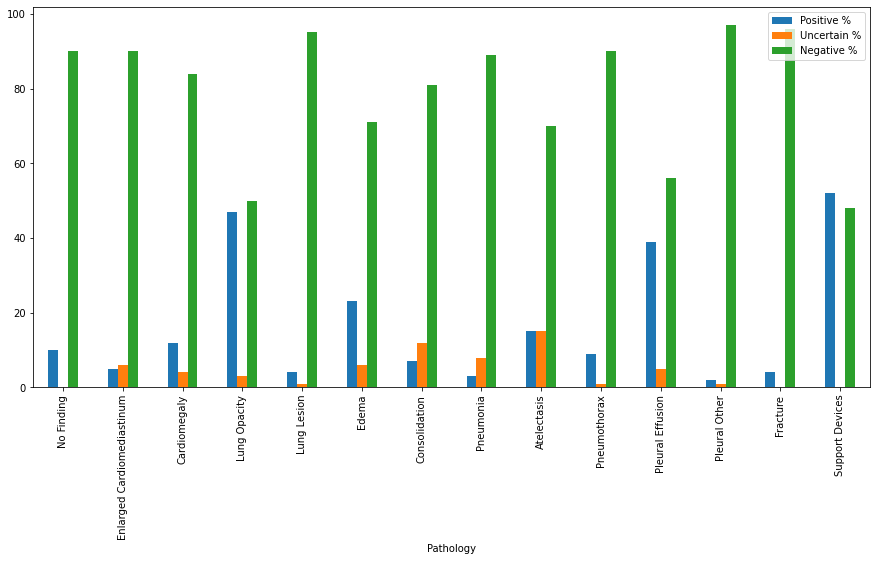

In [31]:
df.fillna(0)[['Positive %', 'Uncertain %', 'Negative %']].copy().plot(kind='bar', figsize=(15,7))

In addition to the labels, we have patient-related features and picture metadata in the dataset.

In [17]:
column_names = np.array(train_labels.columns)
print('Patient Information: ', column_names[2:4])
print('Metadata: ', column_names[4:6])

Patient Information:  ['Age' 'Frontal/Lateral']
Metadata:  ['AP/PA' 'No Finding']


## Images

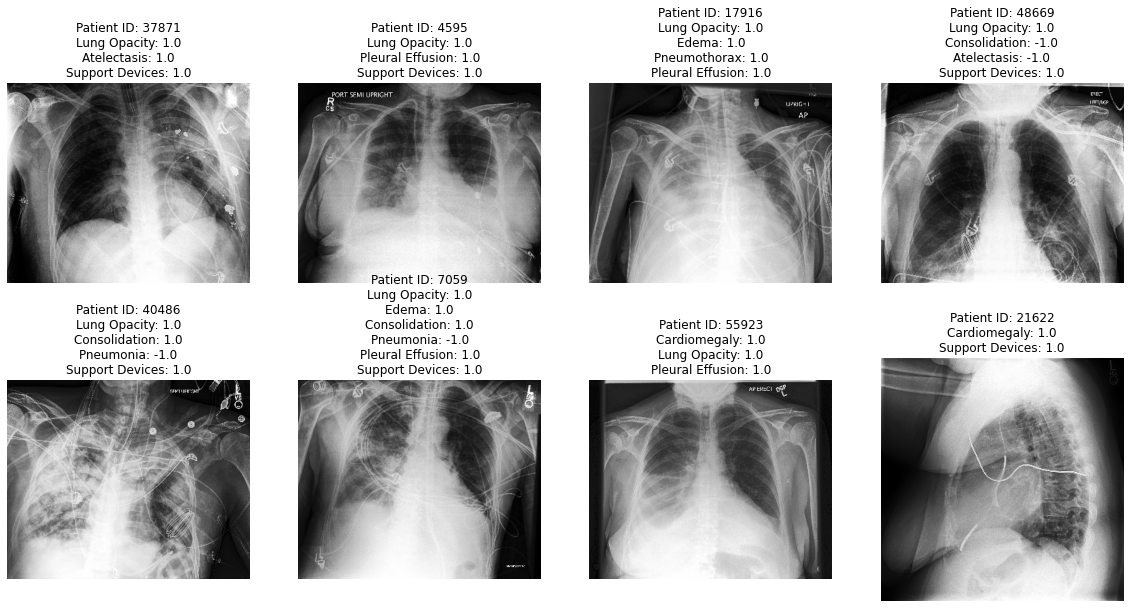

In [18]:
# Randomly sample 8 images
imgs = train_labels['Path'].to_numpy()
imgs_samples = train_labels.sample(n=8, random_state=1)

# Plot random sample of 8 images
plt.figure(figsize=(20, 10))
for i in range(len(imgs_samples)):
    img = cv2.imread(str(chexpert_folder / imgs_samples.Path.to_list()[i]))
    title = "Patient ID: " + str(imgs_samples['patient_id'].to_list()[i])
    for label in labels:
        label_value = imgs_samples[label].to_list()[i]
        if label_value != 0.0 and not math.isnan(label_value):
            title += '\n' + label + ': ' + str(imgs_samples[label].to_list()[i])
    # Plot the image
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
plt.show()


The pictures in the dataset are of varying size, so we take a look at the dimensions of the images. This information needs to be
considered when preprocessing the dataset.

In [19]:
# Prints all the different dimensions that images have
frontal_dimensions = []
lateral_dimensions = []
for index, row in train_labels.iterrows():
    image = cv2.imread(str(chexpert_folder / row['Path']))
    if row['Frontal/Lateral'] == 'Frontal':
        frontal_dimensions.append((image.shape[0], image.shape[1]))
    else:
        lateral_dimensions.append((image.shape[0], image.shape[1]))

In [20]:
frontal = pd.Series(frontal_dimensions)
frontal.value_counts()

(320, 390)    134602
(320, 389)     21871
(320, 320)     13163
(320, 369)      3432
(320, 371)      1590
               ...  
(320, 524)         1
(342, 320)         1
(320, 489)         1
(320, 689)         1
(320, 652)         1
Length: 264, dtype: int64

In [21]:
lateral = pd.Series(lateral_dimensions)
lateral.value_counts()

(320, 320)    8629
(390, 320)    5657
(369, 320)    4925
(371, 320)    2063
(368, 320)     704
              ... 
(320, 405)       1
(320, 379)       1
(320, 395)       1
(486, 320)       1
(474, 320)       1
Length: 249, dtype: int64